In [12]:
# Data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text processing
import re
import string
import nltk
from nltk.corpus import stopwords

# Machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

# Download stopwords (run once)
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
# Load the tweet dataset
df = pd.read_csv('/kaggle/input/tweets-data/tweet_data.csv')

# Drop unnecessary columns
df = df.drop(['id', 'date', 'user'], axis=1)

# Basic dataset overview
print(df.info())
print(df['target'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  240000 non-null  int64 
 1   text    240000 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.7+ MB
None
target
1    120000
0    120000
Name: count, dtype: int64


In [14]:
# Preview the first 10 rows of the dataset
df.head(10)

,target,text
0,1,I Have Something Good In My Life And Just Want...
1,1,Back online
2,1,@NathanFillion What about apartment building m...
3,1,"@Coombsy1989 they announced fable 3... sorta,"
4,0,"@iamizzap i know, i feel bad for the leak too...."
5,1,on our way to kean!! w00t
6,1,"@HaidaFauzi wah, topaz ring - in blue? said to..."
7,1,"Costco, the Getty, THREE HOURS of traffic, tac..."
8,0,@toddzelin What's wrong with her? She going t...
9,1,@babygirlparis Have fun! Have u seen yourself ...


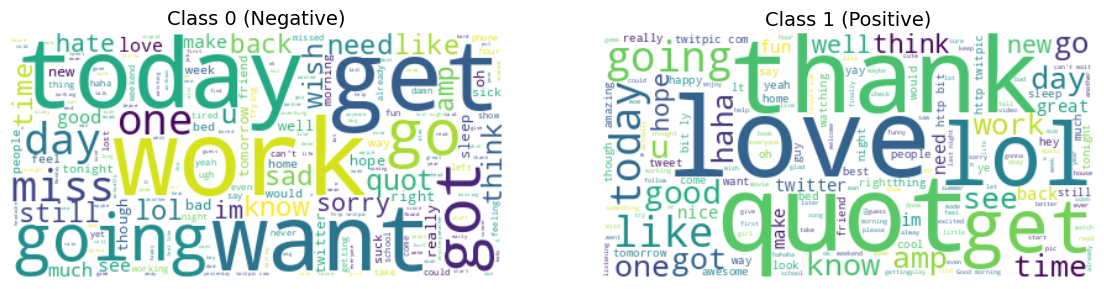

In [15]:
# Separate text by sentiment class
text_class_0 = ' '.join(df[df['target'] == 0]['text'])
text_class_1 = ' '.join(df[df['target'] == 1]['text'])

# Define stopwords
stop_words = set(stopwords.words('english'))

# Generate and plot word clouds
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

wordcloud_0 = WordCloud(stopwords=stop_words, background_color='white').generate(text_class_0)
axes[0].imshow(wordcloud_0, interpolation='bilinear')
axes[0].set_title('Class 0 (Negative)', fontsize=14)
axes[0].axis('off')

wordcloud_1 = WordCloud(stopwords=stop_words, background_color='white').generate(text_class_1)
axes[1].imshow(wordcloud_1, interpolation='bilinear')
axes[1].set_title('Class 1 (Positive)', fontsize=14)
axes[1].axis('off')

plt.show()


In [52]:
# Default stopwords from NLTK
stop_words = set(stopwords.words('english'))

# Set of negation words to KEEP
negation_words = {
    "not", "no", "nor", "n't", "never", "none", "nobody", "nothing", 
    "neither", "nowhere", "hardly", "scarcely", "barely", "without", "cannot"
}

# Remove negation words from stopwords list
custom_stop_words = stop_words - negation_words

# Basic text cleaning function
def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = text.split()
    # Remove stopwords but KEEP negation words
    tokens = [word for word in tokens if word not in custom_stop_words]
    return ' '.join(tokens)


In [53]:
# Apply cleaning and create a new column
df['clean_text'] = df['text'].apply(clean_text)

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Pipeline = TF-IDF → Classifier (NO clean_text here)
pipeline_LR = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train on clean text
pipeline_LR.fit(df['clean_text'], df['target'])

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('classifier', LogisticRegression(max_iter=1000))])

In [55]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate on training data (optional: you can split data if you still want test/train)
y_pred = pipeline_LR.predict(df['clean_text'])

print("Accuracy:", accuracy_score(df['target'], y_pred))
print("\nClassification Report:\n", classification_report(df['target'], y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(df['target'], y_pred))


Accuracy: 0.789125

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.77      0.79    120000
           1       0.78      0.81      0.79    120000

    accuracy                           0.79    240000
   macro avg       0.79      0.79      0.79    240000
weighted avg       0.79      0.79      0.79    240000


Confusion Matrix:
 [[92789 27211]
 [23399 96601]]


In [57]:
import joblib

# Save entire pipeline (cleaning + tfidf + model)
joblib.dump(pipeline_LR, 'logistic_regression_pipeline.pkl')
print("✅ Pipeline saved successfully!")


✅ Pipeline saved successfully!


In [58]:
# Sample tweet as a pandas Series
sample_tweet = pd.Series(["I do not like the food here"])

# Predict sentiment
prediction = pipeline_LR.predict(sample_tweet)[0]

sentiment = "Positive" if prediction == 1 else "Negative"
print(f"Predicted Sentiment: {sentiment}")


Predicted Sentiment: Negative
